In [1]:
from collections import defaultdict
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import xml.etree.ElementTree as ET

In [188]:
%matplotlib inline

In [2]:
tohme_file = "/mnt/c/Users/gweld/sidewalk/sidewalk_ml/tohme/mysql_tohme.tsv"
path_to_scrapes = '/mnt/e/tohme_panos/tohme_data/GSV/'

In [3]:
class TohmeObject(object):
    def __init__(self):
        self.corners = []
        
        self.LabelId = None
        self.pano_id = None
        self.LabelTypeId = None
        # note: these ogHeading and ogPitch appear to vary across features
        #self.originalHeading = None
        #self.originalPitch = None
        #self.labelLat = None
        #self.labelLng = None
        return
    
    def __len__(self):
        return len(self.corners)
    
    def add_corner(self, row):
        err_str = "{} {} for LabelId " + str(self.LabelId)
        
        if self.LabelId is None:
            self.LabelId = int(row[0])
        else:
            assert self.LabelId == int(row[0]), err_str.format(self.LabelId, int(row[0]))
            
        if self.LabelTypeId is None:
            self.LabelTypeId = int(row[2])
        else:
            assert self.LabelTypeId == int(row[2]), err_str.format(self.LabelTypeId, int(row[2]))
        
        if self.pano_id is None:
            self.pano_id = row[1]
        else:
            assert self.pano_id == row[1], err_str.format(self.pano_id, row[1])
            
        sv_x, sv_y = int(row[3]), int(row[4])
        self.corners.append((sv_x, sv_y))
        
    def show_poly(self, bbox=True):
        ''' show the shape of the polygon.
            bbox toggles showing the square bounding box
        '''
        xs, ys = zip(*self.corners)
        plt.plot(xs+xs[0:1], ys+ys[0:1])
        if bbox:
            bxs, bys = zip(*self.bbox())
            plt.plot(bxs, bys)
        cx, cy = self.center()
        plt.scatter(cx, cy, s=4)
        plt.title("Shape of polygon for label{}".format(self.LabelId))
        if bbox: plt.axis('square')
        plt.show()
        
    def center(self):
        ''' return the centroid '''
        xs, ys = zip(*self.corners)
        
        cx = float(sum(xs))/len(self)
        cy = float(sum(ys))/len(self)
        return cx, cy
        
    def bbox(self):
        ''' return the smallest square containing all poly corners '''
        xs, ys = zip(*self.corners)
        top    = max(ys)
        bottom = min(ys)
        left   = min(xs)
        right  = max(xs)
        
        width = right-left
        height = top-bottom
        
        
        if width > height:
            padding = (width-height)/2
            bottom -= padding
            top += padding
            
        else:
            padding = (height-width)/2
            left -= padding
            top += padding
        
        return ((left, top),(right,top),(right,bottom),(left,bottom),(left,top))
    
    def __hash__(self):
        return int.__hash__(self.LabelId)
    
    def __contains__(self, other):
        if self.pano_id != other.pano_id:
            return False
        
        contains = True
        for corner in other.corners:
            if corner not in self.corners:
                contains = False
                
        return contains

In [4]:
def get_tohme_img(pano_id):
    imgpath = os.path.join(path_to_scrapes, pano_id, "images", 'pano.jpg')
    return Image.open(imgpath, 'r')

In [168]:
def get_tohme_meta(pano_id):
    metapath = os.path.join(path_to_scrapes, pano_id, "meta.xml")
    root =  ET.parse(metapath).getroot()

    d = dict()
    
    dp = root.find('data_properties')
    for key in ('lat', 'lng'):
        d[key] = float(dp.attrib[key])
    for c in dp:
        if c.tag == 'copyright': continue
        d[c.tag] = c.text
    pp = root.find('projection_properties')
    for key in ('pano_yaw_deg','tilt_pitch_deg', 'tilt_yaw_deg'):
        d[key] = float(pp.attrib[key])
    return d

In [109]:
with open(tohme_file) as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        print ' '.join(row)
        break

LabelId LabelGSVPanoramaId LabelTypeId svImageX svImageY originalCanvasX originalCanvasY originalHeading heading originalPitch pitch labelLat labelLng


In [5]:
features = defaultdict(TohmeObject)
panos = set()

with open(tohme_file) as f:
    reader = csv.reader(f, delimiter='\t')
    reader.next() # skip header
    for row in reader:
        LabelId = int(row[0])
        features[LabelId].add_corner(row)
        
        pano = row[1]
        panos.add(pano)
        
print "created {} features".format(len(features))
num_panos = len(panos)
print "found {} unique panos".format(num_panos)
label_types = set([f.LabelTypeId for f in features.values()])
print "found {} different labels:{}".format(len(label_types), label_types)

created 234282 features
found 1091 unique panos
found 4 different labels:set([1, 2, 3, 4])


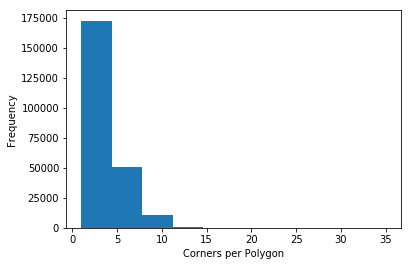

In [6]:
plt.hist([len(f) for f in features.values()])
plt.xlabel("Corners per Polygon")
plt.ylabel("Frequency")
plt.show()

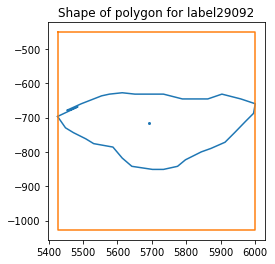

In [7]:
biggest_feat = max(features.values(), key=len)
biggest_feat.show_poly()

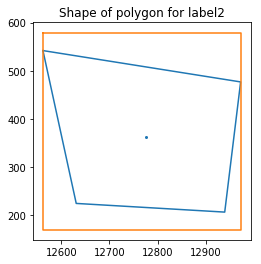

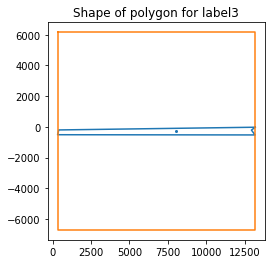

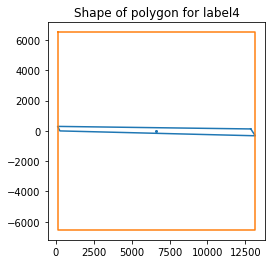

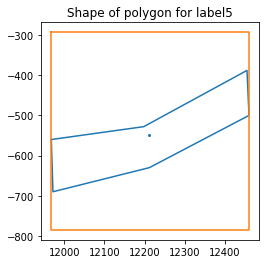

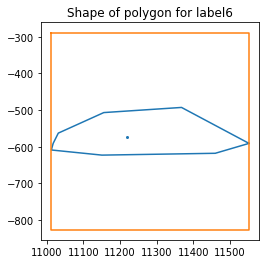

In [8]:
for feat in features.values()[:5]:
    feat.show_poly()

In [9]:
panos = defaultdict(list)
for feat in features.values():
    panos[feat.pano_id].append(feat)
print "got features for {} panos.".format(len(panos))

got features for 1091 panos.


In [10]:
len(panos)

1091

In [11]:
biggest_pano, feats_in_biggest_pano = max(panos.items(), key=lambda x: len(x[1]))
print "biggest pano {} has {} feats".format(biggest_pano, len(feats_in_biggest_pano))

biggest pano bAmnPp8nMBThG6KNuPpDUg has 9406 feats


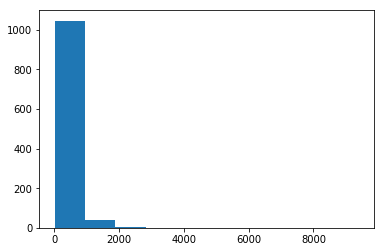

In [12]:
plt.hist([len(p) for p in panos.values()])
plt.show()

In [13]:
len(feats_in_biggest_pano)

9406

In [64]:
counter = defaultdict(int)
for f in features.values():
    counter[f.LabelTypeId] += 1
print counter

defaultdict(<type 'int'>, {1: 212900, 2: 13175, 3: 169, 4: 8038})


In [14]:
dupes = 0
corners = set()
for feat in feats_in_biggest_pano:
    for corner in feat.corners:
        if str(corner) in corners: dupes += 1
        else: corners.add(str(corner))
print dupes

36987


In [15]:
len(corners)

962

In [40]:
img_array = np.asarray(get_tohme_img(biggest_pano))

In [61]:
pano_yaw_degree = 139.84
pano_yaw_degree = pano_yaw_degree - 100

xs, ys = [], []
for corner in corners:
    sv_image_x, sv_image_y = corner.split(',')
    sv_image_x = int(sv_image_x[1:])
    sv_image_y = int(sv_image_y[:-1])
    
    x = ((float(pano_yaw_degree) / 360) * 13312 + sv_image_x) % 13312
    y = 6656 / 2 - sv_image_y
    
    xs.append(x)
    ys.append(y)

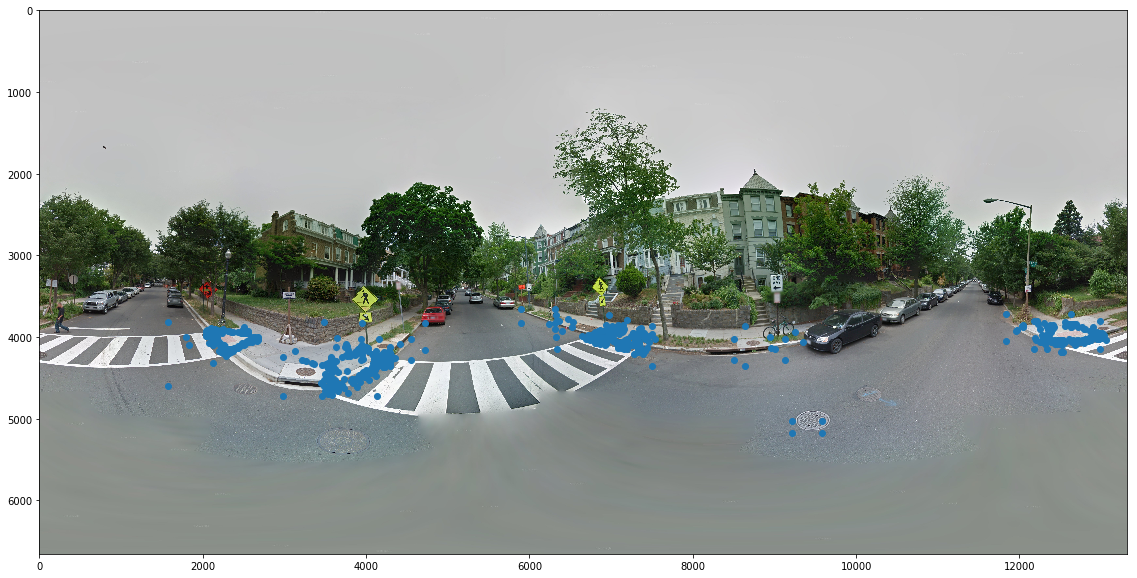

In [62]:
plt.figure(figsize=(20,10))
plt.scatter(xs, ys)
#plt.imshow(img_array, extent=[0, 13312, -3328, 3328])
plt.imshow(img_array)
#plt.xlim((0, 13312))
#plt.ylim(-3328, 3328)
plt.show()

In [107]:
get_tohme_meta(biggest_pano)

{'lat': 38.928799,
 'lng': -77.038869,
 'pano_yaw_deg': 139.84,
 'tilt_pitch_deg': 3.24,
 'tilt_yaw_deg': 90.58}

In [192]:
def show_pano(pano_id, shift=0):
    label_to_color = {1:'b', 2:'g', 3:'r', 4:'y'}
    
    img_array = np.asarray(get_tohme_img(pano_id))
    meta = get_tohme_meta(pano_id)
    pano_yaw_degree = meta["pano_yaw_deg"] + shift
    
    feats = panos[pano_id]
    xs, ys, cs = [], [], []
    for f in feats:
        for sv_image_x, sv_image_y in f.corners:
            x = ((float(pano_yaw_degree) / 360) * 13312 + sv_image_x) % 13312
            y = 6656 / 2 - sv_image_y

            xs.append(x)
            ys.append(y)
            
            cs.append(label_to_color[f.LabelTypeId])
    
    location = meta['text'] + "\n" + meta['region']
    plt.figure(figsize=(30,15))
    plt.scatter(xs, ys, c=cs)
    plt.imshow(img_array)
    plt.title(location)
    plt.show()

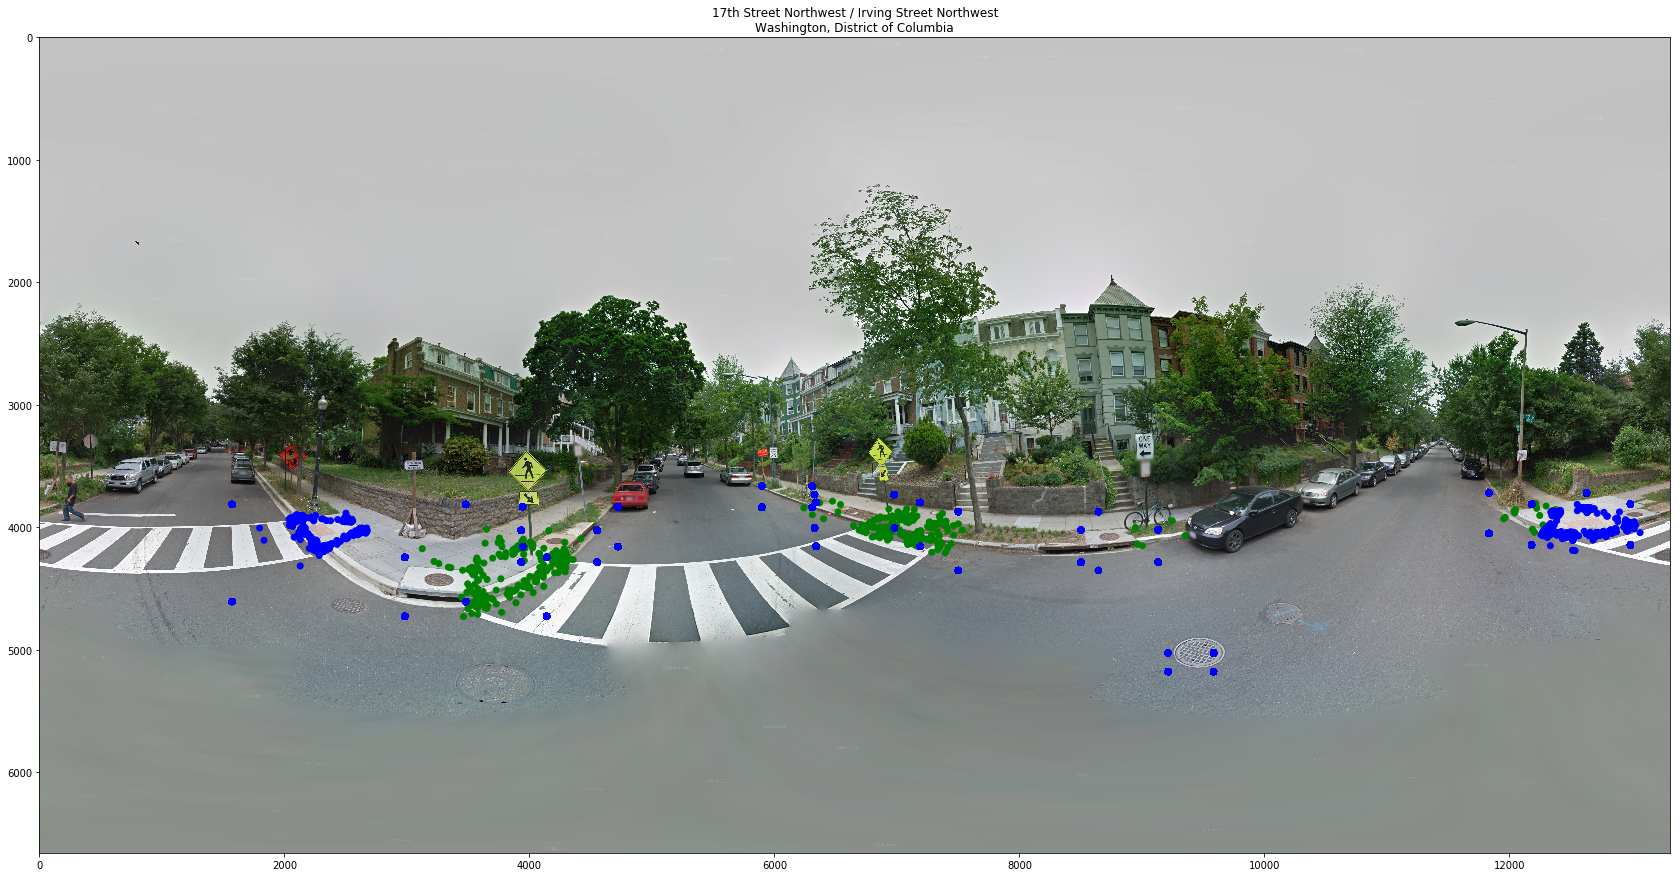

In [193]:
show_pano(biggest_pano, -100)

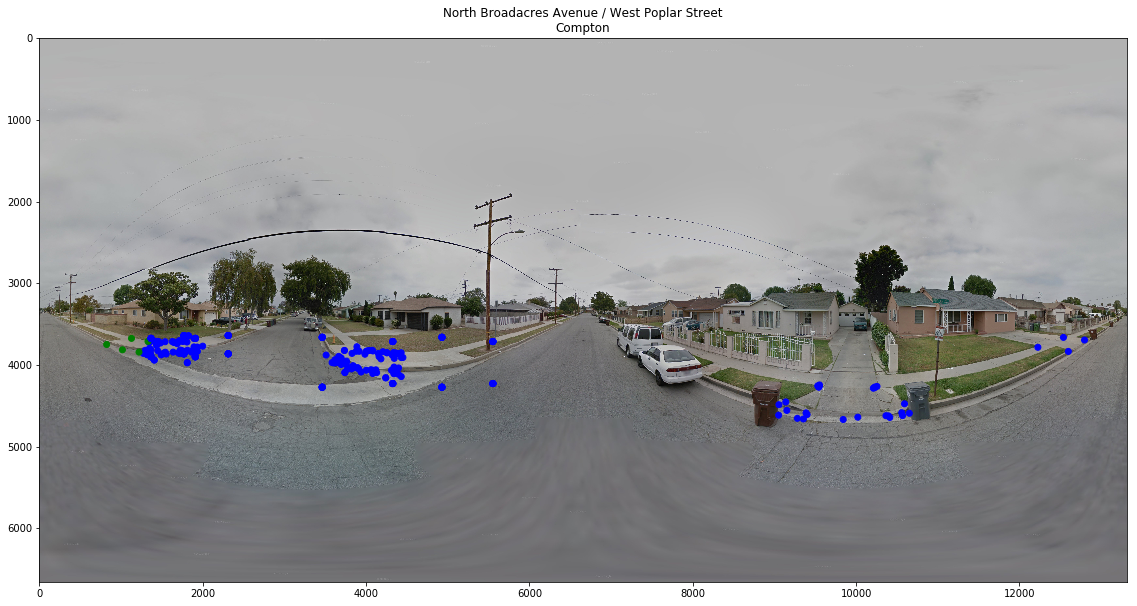

In [180]:
show_pano(panos.keys()[14])

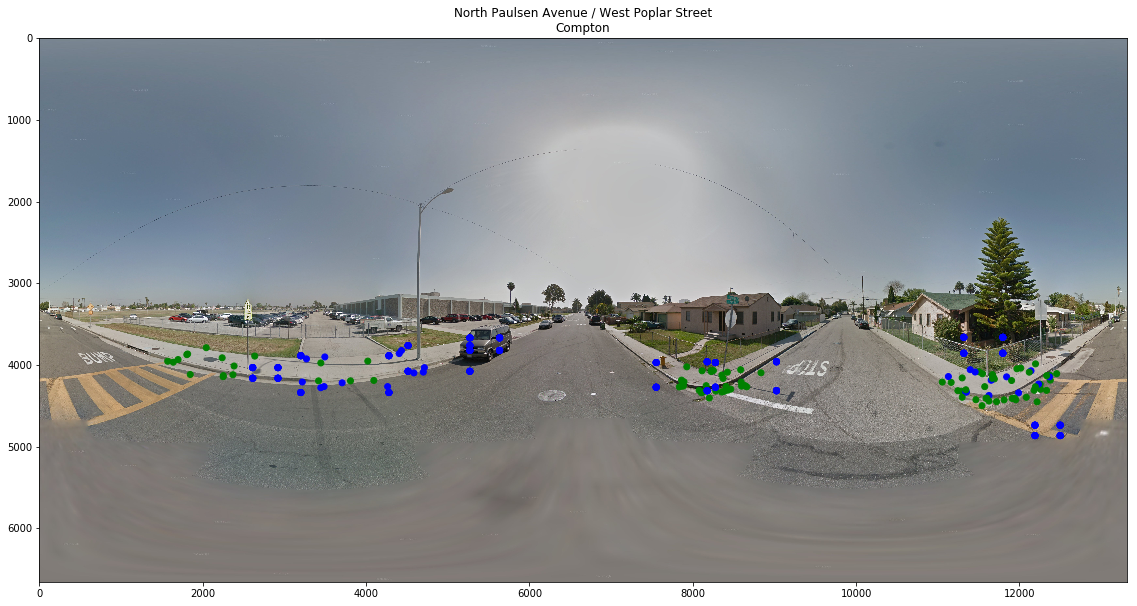

In [181]:
show_pano(panos.keys()[499], 0)

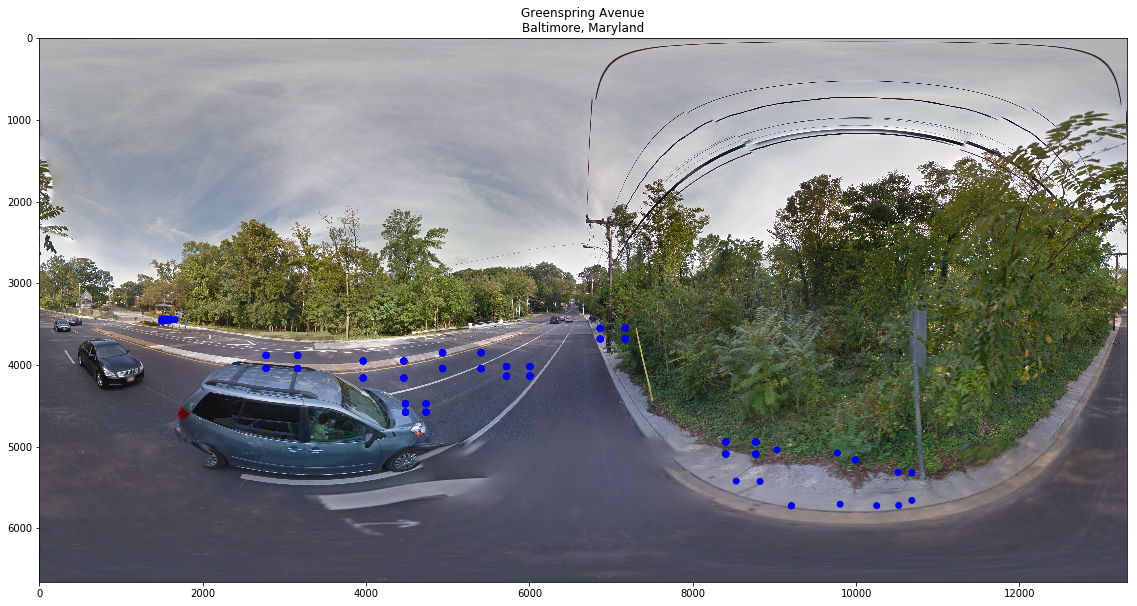

In [183]:
show_pano(panos.keys()[100], -100)